<a href="https://colab.research.google.com/github/rubenesticesi/Data-Science-For-Beginners/blob/main/Ejercicio3_ARIMA_Ocupados_13ciudades_Grupo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


#  Aprendizaje Automático (clase 3) Profesores :
# Diego Fernando Agudelo - Daniel Felipe Osorio
# Universidad ICESI

## Taller o Ejercicio  No 3 Presentado por :
## Edwin Perez - Cristian Quebrada - Rubén Darío Sabogal

------------------------------------------------------

# Ejercicio 7 – Pronóstico de Ocupados con ARIMA(0,1,1)

Este cuaderno replica la estructura de trabajo de **`Aprendizaje_automático_III_clase3.ipynb`** para la serie mensual de **Ocupados (miles de personas)** en las 13 principales ciudades:

a. Carga de paquetes.
b. Carga de datos.
c. ACF y PACF.
d. Pronóstico con el modelo ARIMA(0,1,1) (modelo sugerido por `auto.arima`).
e. Replicación del modelo ARIMA(0,1,1) sin usar `auto.arima`.
f. Intervalos de confianza usando **bootstrap**.
g. Tablas y gráficos correspondientes.

Al final se comparan los resultados con el mejor modelo del **Taller 2 (Holt–Winters aditivo)**.

## a) Carga de paquetes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

plt.rcParams['figure.figsize'] = (10, 4)
plt.rcParams['axes.grid'] = True


## b) Carga de datos

In [2]:
# Cargar el archivo datosEmpleo.xlsx (debe estar en el mismo directorio en Colab)
data = pd.read_excel('datosEmpleo.xlsx')
data['mes'] = pd.to_datetime(data['mes'])
data = data.set_index('mes')

# Nos quedamos con la serie de interés
y = data['Ocupados'].asfreq('MS')  # frecuencia mensual (inicio de mes)

y.head()

,Ocupados
mes,
2001-01-01,6923.604
2001-02-01,7037.746
2001-03-01,6945.973
2001-04-01,6973.079
2001-05-01,6994.462


count      222.000000
mean      9160.852009
std       1295.492800
min       6923.604000
25%       7971.103000
50%       9139.064500
75%      10458.510250
max      11037.199000
Name: Ocupados, dtype: float64


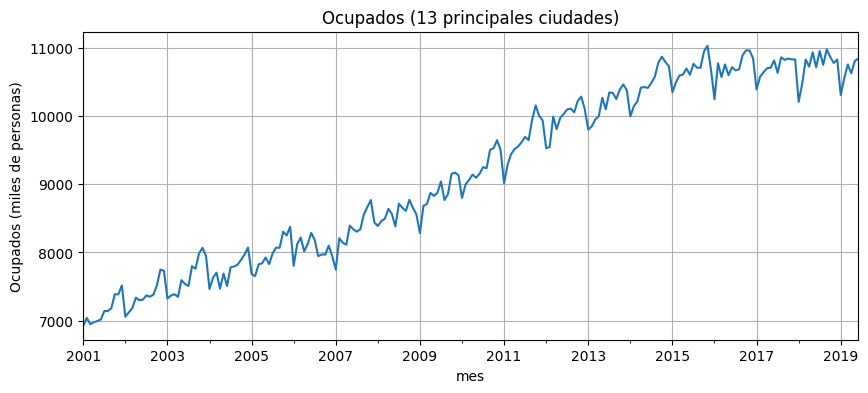

In [3]:
# Información general de la serie
print(y.describe())
ax = y.plot(title='Ocupados (13 principales ciudades)')
ax.set_ylabel('Ocupados (miles de personas)')
plt.show()

## c) ACF y PACF
Primero inspeccionamos la ACF/PACF de la serie original y de la serie diferenciada para motivar un modelo ARIMA(0,1,1).

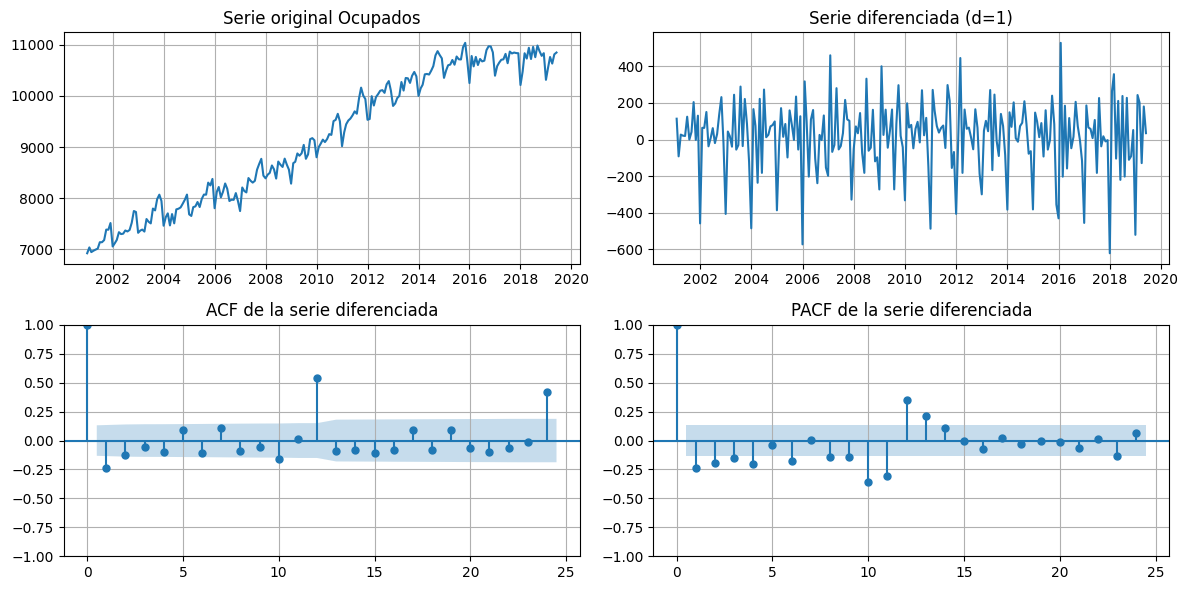

In [4]:
# Diferenciación de primer orden (d = 1)
dy = y.diff().dropna()
fig, axes = plt.subplots(2, 2, figsize=(12, 6))

# Serie original
axes[0, 0].plot(y)
axes[0, 0].set_title('Serie original Ocupados')

# Serie diferenciada
axes[0, 1].plot(dy)
axes[0, 1].set_title('Serie diferenciada (d=1)')

# ACF y PACF de la serie diferenciada
plot_acf(dy, lags=24, ax=axes[1, 0])
axes[1, 0].set_title('ACF de la serie diferenciada')
plot_pacf(dy, lags=24, ax=axes[1, 1])
axes[1, 1].set_title('PACF de la serie diferenciada')

plt.tight_layout()
plt.show()

In [5]:
# Tabla de valores ACF/PACF para los primeros 10 rezagos de la serie diferenciada
acf_vals = acf(dy, nlags=10)
pacf_vals = pacf(dy, nlags=10)

tabla_acf_pacf = pd.DataFrame({
    'lag': np.arange(len(acf_vals)),
    'ACF': acf_vals,
    'PACF': pacf_vals
})
tabla_acf_pacf

,lag,ACF,PACF
0,0,1.000000,1.000000
1,1,-0.238406,-0.239489
2,2,-0.122622,-0.192116
3,3,-0.055560,-0.151635
4,4,-0.095619,-0.203553
5,5,0.089559,-0.039293
6,6,-0.106095,-0.181565
7,7,0.105970,0.003484
8,8,-0.091785,-0.147274
9,9,-0.051853,-0.149092


## d) Pronóstico ARIMA(0,1,1) (modelo sugerido por `auto.arima`)
En el cuaderno original en R, la función `auto.arima` sugiere un modelo ARIMA(0,1,1).
Aquí ajustamos ese modelo usando sólo los **últimos 6 meses** como conjunto de prueba.

In [6]:
h = 6  # horizonte de prueba
train = y.iloc[:-h]
test = y.iloc[-h:]

print('Período de entrenamiento:', train.index.min().date(), '→', train.index.max().date())
print('Período de prueba:      ', test.index.min().date(), '→', test.index.max().date())

# Ajuste del ARIMA(0,1,1) en el conjunto de entrenamiento
model_train = ARIMA(train, order=(0, 1, 1))
fit_train = model_train.fit()
print(fit_train.summary())

Período de entrenamiento: 2001-01-01 → 2018-12-01
Período de prueba:       2019-01-01 → 2019-06-01
                               SARIMAX Results                                
Dep. Variable:               Ocupados   No. Observations:                  216
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1423.147
Date:                Thu, 13 Nov 2025   AIC                           2850.295
Time:                        19:41:52   BIC                           2857.036
Sample:                    01-01-2001   HQIC                          2853.019
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3589      0.071     -5.050      0.000      -0.498      -0.220
sigma2      3.274e+04   2605.512

In [7]:
# Pronóstico sobre el conjunto de prueba
forecast_test = fit_train.forecast(steps=h)

def rmse(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

rmse_arima = rmse(test.values, forecast_test.values)
print('RMSE ARIMA(0,1,1) en prueba (6 meses):', rmse_arima)

tabla_prueba = pd.DataFrame({
    'Observado': test.values,
    'Pronosticado_ARIMA_0_1_1': forecast_test.values
}, index=test.index)
tabla_prueba

RMSE ARIMA(0,1,1) en prueba (6 meses): 253.5109851209457


,Observado,Pronosticado_ARIMA_0_1_1
mes,,
2019-01-01,10314.438,10830.556937
2019-02-01,10557.917,10830.556937
2019-03-01,10760.776,10830.556937
2019-04-01,10632.028,10830.556937
2019-05-01,10813.000,10830.556937
2019-06-01,10848.000,10830.556937


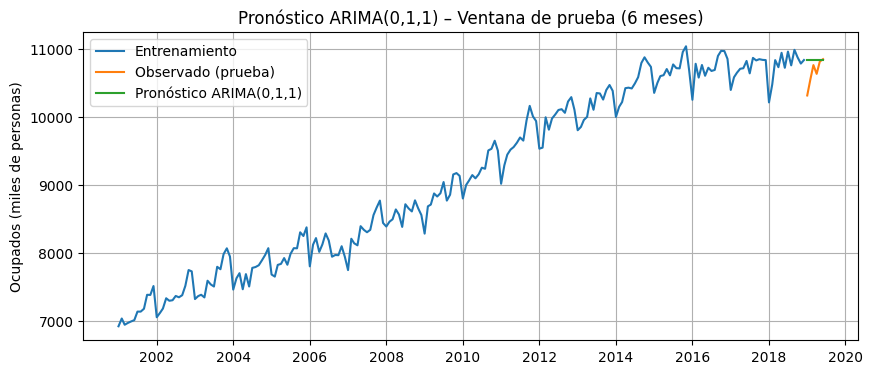

In [8]:
# Gráfico Observados vs Pronosticados en la ventana de prueba
plt.plot(train.index, train.values, label='Entrenamiento')
plt.plot(test.index, test.values, label='Observado (prueba)')
plt.plot(forecast_test.index, forecast_test.values, label='Pronóstico ARIMA(0,1,1)')
plt.title('Pronóstico ARIMA(0,1,1) – Ventana de prueba (6 meses)')
plt.ylabel('Ocupados (miles de personas)')
plt.legend()
plt.show()

## e) Replicando el modelo ARIMA(0,1,1) sin `auto.arima`
Ahora ajustamos manualmente el modelo ARIMA(0,1,1) sobre **toda la serie** para generar el pronóstico final de los próximos 6 meses.

In [9]:
# Ajuste manual ARIMA(0,1,1) sobre la serie completa
model_full = ARIMA(y, order=(0, 1, 1))
fit_full = model_full.fit()
print(fit_full.summary())

h = 6
forecast_6 = fit_full.forecast(steps=h)
forecast_6

                               SARIMAX Results                                
Dep. Variable:               Ocupados   No. Observations:                  222
Model:                 ARIMA(0, 1, 1)   Log Likelihood               -1465.282
Date:                Thu, 13 Nov 2025   AIC                           2934.564
Time:                        19:42:03   BIC                           2941.360
Sample:                    01-01-2001   HQIC                          2937.308
                         - 06-01-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3666      0.072     -5.109      0.000      -0.507      -0.226
sigma2      3.347e+04   2615.636     12.795      0.000    2.83e+04    3.86e+04
Ljung-Box (L1) (Q):                   0.37   Jarque-

,predicted_mean
2019-07-01,10813.166572
2019-08-01,10813.166572
2019-09-01,10813.166572
2019-10-01,10813.166572
2019-11-01,10813.166572
2019-12-01,10813.166572


In [10]:
# Tabla de pronósticos puntuales (ARIMA(0,1,1))
forecast_df = forecast_6.to_frame(name='Pronóstico_ARIMA_0_1_1')
forecast_df

,Pronóstico_ARIMA_0_1_1
2019-07-01,10813.166572
2019-08-01,10813.166572
2019-09-01,10813.166572
2019-10-01,10813.166572
2019-11-01,10813.166572
2019-12-01,10813.166572


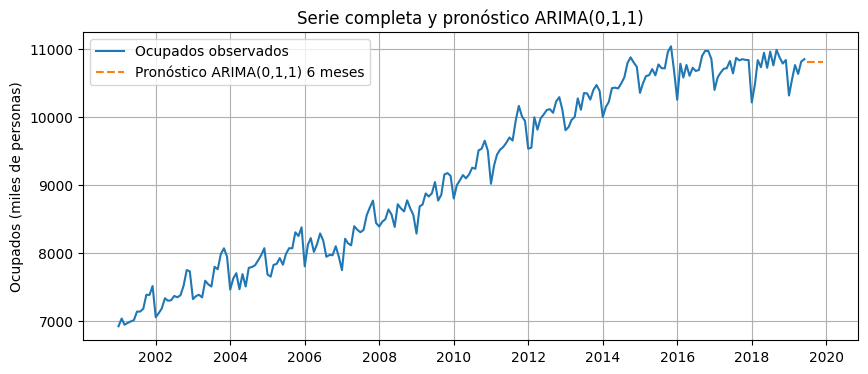

In [11]:
# Gráfico de la serie completa y pronóstico ARIMA(0,1,1)
plt.plot(y.index, y.values, label='Ocupados observados')
plt.plot(forecast_6.index, forecast_6.values, '--', label='Pronóstico ARIMA(0,1,1) 6 meses')
plt.title('Serie completa y pronóstico ARIMA(0,1,1)')
plt.ylabel('Ocupados (miles de personas)')
plt.legend()
plt.show()

## f) Intervalos de confianza usando bootstrap

Para aproximar la distribución de los pronósticos se implementa un **bootstrap de residuales** del ARIMA(0,1,1) sobre la serie completa.
Se generan B trayectorias futuras re-muestreando residuales y se obtienen intervalos de confianza del 95%.

In [12]:
resid = fit_full.resid.dropna()
theta = fit_full.params.get('ma.L1', fit_full.params[0])

B = 500
h = 6
last_y = y.iloc[-1]
last_e = resid.iloc[-1]

boot_paths = np.zeros((B, h))
rng = np.random.default_rng(123)

for b in range(B):
    y_future = [last_y]
    e_prev = last_e
    for k in range(h):
        e_t = rng.choice(resid.values)
        w_t = e_t + theta * e_prev
        y_new = y_future[-1] + w_t
        y_future.append(y_new)
        e_prev = e_t
    boot_paths[b, :] = y_future[1:]

lower = np.quantile(boot_paths, 0.025, axis=0)
upper = np.quantile(boot_paths, 0.975, axis=0)

forecast_table = pd.DataFrame({
    'Fecha': forecast_6.index,
    'Pronóstico_ARIMA_0_1_1': forecast_6.values,
    'LI_95_Bootstrap': lower,
    'LS_95_Bootstrap': upper
})
forecast_table

/tmp/ipython-input-690819611.py:2: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  theta = fit_full.params.get('ma.L1', fit_full.params[0])


,Fecha,Pronóstico_ARIMA_0_1_1,LI_95_Bootstrap,LS_95_Bootstrap
0,2019-07-01,10813.166572,10406.141320,11133.919934
1,2019-08-01,10813.166572,10322.744560,11211.685935
2,2019-09-01,10813.166572,10292.247709,11364.637851
3,2019-10-01,10813.166572,10268.538782,11480.883694
4,2019-11-01,10813.166572,10263.020228,11584.693813
5,2019-12-01,10813.166572,10249.641717,15005.294926


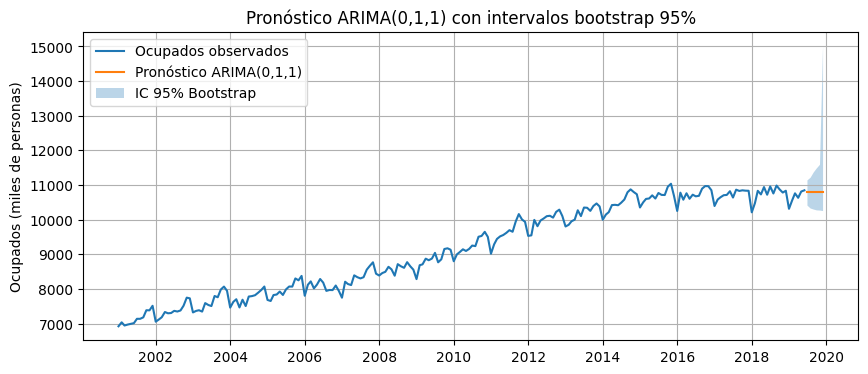

In [13]:
# Gráfico de pronóstico con bandas de confianza bootstrap
plt.plot(y.index, y.values, label='Ocupados observados')
plt.plot(forecast_6.index, forecast_6.values, label='Pronóstico ARIMA(0,1,1)')
plt.fill_between(
    forecast_6.index,
    forecast_table['LI_95_Bootstrap'],
    forecast_table['LS_95_Bootstrap'],
    alpha=0.3,
    label='IC 95% Bootstrap'
)
plt.title('Pronóstico ARIMA(0,1,1) con intervalos bootstrap 95%')
plt.ylabel('Ocupados (miles de personas)')
plt.legend()
plt.show()

## g) Resumen y comparación con el mejor modelo del Taller 2

- El RMSE de **ARIMA(0,1,1)** en la ventana de prueba de 6 meses se guarda en `rmse_arima`.
- En el **Taller 2**, el mejor modelo fue **Holt–Winters aditivo**, con un RMSE promedio en validación de aproximadamente **176** ocupados (en miles), medido sobre horizontes de 1 a 6 meses.
- Aquí podemos construir una pequeña tabla de comparación manualmente.

In [14]:
rmse_taller2_hw = 176  # RMSE promedio reportado para Holt-Winters aditivo en Taller 2
comparacion_rmse = pd.DataFrame({
    'Modelo': ['ARIMA(0,1,1)', 'Holt-Winters aditivo (Taller 2)'],
    'RMSE_aproximado': [rmse_arima, rmse_taller2_hw]
})
comparacion_rmse

,Modelo,RMSE_aproximado
0,"ARIMA(0,1,1)",253.510985
1,Holt-Winters aditivo (Taller 2),176.000000
